In [1]:
!pip install PyTDC

# Установка библиотеки rdkit
!pip install rdkit

# Установка библиотеки mordred
!pip install mordred

# Установка библиотеки catboost
!pip install catboost

In [2]:
from tdc.single_pred import ADME, Tox
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, r2_score
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import os
import pickle
from mordred import Calculator, descriptors
from tdc.utils import retrieve_dataset_names

from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.metrics import roc_curve
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# смотрим список датасетов ADME
dataset_names_ADME = retrieve_dataset_names(name='ADME')
print(dataset_names_ADME)
# смотрим список датасетов Tox
dataset_names_Tox = retrieve_dataset_names(name='Tox')
print(dataset_names_Tox)

['lipophilicity_astrazeneca', 'solubility_aqsoldb', 'hydrationfreeenergy_freesolv', 'caco2_wang', 'pampa_ncats', 'approved_pampa_ncats', 'hia_hou', 'pgp_broccatelli', 'bioavailability_ma', 'vdss_lombardo', 'cyp2c19_veith', 'cyp2d6_veith', 'cyp3a4_veith', 'cyp1a2_veith', 'cyp2c9_veith', 'cyp2c9_substrate_carbonmangels', 'cyp2d6_substrate_carbonmangels', 'cyp3a4_substrate_carbonmangels', 'bbb_martins', 'b3db_classification', 'b3db_regression', 'ppbr_az', 'half_life_obach', 'clearance_hepatocyte_az', 'clearance_microsome_az', 'hlm', 'rlm']
['tox21', 'toxcast', 'clintox', 'herg_karim', 'herg', 'herg_central', 'dili', 'skin_reaction', 'ames', 'carcinogens_lagunin', 'ld50_zhu']


In [4]:
# Define datasets and task mapping
datasets = {
    "regression": ['pampa_ncats', "ppbr_az", 'Clearance_Hepatocyte_AZ'],
    "classification": ['cyp2d6_veith', 'CYP3A4_Substrate_CarbonMangels', 'DILI']
}

Датасет pampa_ncat относится к категории ADME. PAMPA (Parallel Artificial Membrane Permeability Assay) — это метод, используемый для оценки проницаемости веществ через искусственные мембраны. Метод PAMPA является упрощённой моделью, которая не учитывает все аспекты биологических систем, но полезна для высокопроизводительного скрининга. Часто используется в комбинации с другими методами, такими как Caco-2, для более точной оценки.  
Все датасеты связаны с ферментами цитохрома P450 (CYP), которые играют ключевую роль в метаболизме лекарственных препаратов. Названия датасетов указывают на конкретные изоформы ферментов: CYP2C19, CYP2D6, CYP3A4, CYP1A2, CYP2C9.
Набор данных DILI (Drug-Induced Liver Injury) содержит информацию о лекарственных средствах, у которых наблюдались случаи поражения печени, включается в задачи классификации.

In [5]:
# Output directory
output_dir = "models"
os.makedirs(output_dir, exist_ok=True)

In [6]:
def smiles_to_features(smiles_list, fingerprint_type="maccs", radius=3, n_bits=1024):
    """
    Преобразует список SMILES в числовые признаки (fingerprints) с использованием RDKit.

    Параметры:
    - smiles_list: список строк SMILES.
    - fingerprint_type: тип отпечатка ("morgan" или "maccs").
    - radius: радиус для Morgan fingerprints (по умолчанию 2).
    - n_bits: длина битовой строки для Morgan fingerprints (по умолчанию 2048).

    Возвращает:
    - Список списков с числовыми признаками.
    """
    features = []

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)  # Конвертируем SMILES в объект молекулы
        if mol:
            try:
                if fingerprint_type == "morgan":
                    # Создаем Morgan fingerprints
                    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
                    features.append(list(fp))
                elif fingerprint_type == "maccs":
                    # Создаем MACCS Keys
                    fp = MACCSkeys.GenMACCSKeys(mol)
                    features.append(list(fp))
                else:
                    raise ValueError(f"Неподдерживаемый тип отпечатка: {fingerprint_type}")
            except Exception as e:
                print(f"Ошибка при расчете отпечатков для {smiles}: {e}")
                features.append(None)
        else:
            print(f"Невозможно интерпретировать SMILES: {smiles}")
            features.append(None)

    return features

In [7]:
def prepare_features_and_targets(df):
    smiles = df['Drug']
    y = df['Y']
    X_features = smiles_to_features(smiles, fingerprint_type="morgan")
    # удаляем значения None из списка признаков
    X_features = [feat for feat, target in zip(X_features, y) if feat is not None]
    # фильтруем целевые значения, соответствующие удаленным признакам
    y = [target for feat, target in zip(X_features, y) if feat is not None]
    return X_features, y

In [8]:
# функция тренировки и сохранения моделей
def train_and_save_model(task, dataset, model,X_train, y_train, X_valid, y_valid, X_test, y_test):
    print(f"Training {task} model for dataset: {dataset}...")
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True, verbose=100)
    model_path = os.path.join(output_dir, f"{dataset}_model.cbm")
    model.save_model(model_path)
    print(f"Model saved to {model_path}")

    # Оценка, все метрики: mse, r2, mae, accuracy, f1, roc_auc
    if task == "regression":
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        print(f"Test MSE: {mse:.2f}")
        print(f"Test R2 Score: {r2:.2f}")
        print(f"Test MAE: {mae:.2f}")
        return {"mse": mse, "r2": r2, "mae": mae, "predictions": predictions, "actuals": y_test}
    elif task == "classification":
        predictions = model.predict(X_test)
        probabilities = model.predict_proba(X_test)[:, 1]  # Вероятность положительного класса
        acc = accuracy_score(y_test, predictions)
        f1 = f1_score(y_test, predictions, average="binary")
        roc_auc = roc_auc_score(y_test, probabilities)
        print(f"Test Accuracy: {acc:.2f}")
        print(f"Test F1 Score: {f1:.2f}")
        print(f"Test ROC-AUC: {roc_auc:.2f}")
        return {"accuracy": acc, "f1": f1, "roc_auc": roc_auc, "predictions": predictions, "actuals": y_test, "probabilities": probabilities}

In [15]:
all_results = {}
# Loop through datasets
for task, task_datasets in datasets.items():
    for dataset in task_datasets:
        print(f"Processing dataset: {dataset}")
        if dataset.lower() in dataset_names_Tox:
          data = Tox(name=dataset)
        else:
          data = ADME(name=dataset)

        splits = data.get_split()

        train_df = pd.DataFrame(splits['train'])
        valid_df = pd.DataFrame(splits['valid'])
        test_df = pd.DataFrame(splits['test'])

        X_train, y_train = prepare_features_and_targets(train_df)
        X_valid, y_valid = prepare_features_and_targets(valid_df)
        X_test, y_test = prepare_features_and_targets(test_df)

        if task == "regression":
            model = CatBoostRegressor(
                iterations=5000,
                loss_function="RMSE"
            )
        elif task == "classification":
            model = CatBoostClassifier(
                iterations=2000,
                loss_function="Logloss"
            )

        results = train_and_save_model(task, dataset, model, X_train, y_train, X_valid, y_valid, X_test, y_test)

        # Save results
        results_path = os.path.join(output_dir, f"{dataset}_results.pkl")
        with open(results_path, "wb") as f:
            pickle.dump(results, f)
        print(f"Results saved to {results_path}")

        # Добавляем результаты в словарь
        all_results[dataset] = results

Found local copy...
Loading...
Done!


Processing dataset: pampa_ncats
Training regression model for dataset: pampa_ncats...
Learning rate set to 0.020166
0:	learn: 0.3461820	test: 0.3693190	best: 0.3693190 (0)	total: 28.8ms	remaining: 2m 24s
100:	learn: 0.3173778	test: 0.3560460	best: 0.3560460 (100)	total: 2.87s	remaining: 2m 18s
200:	learn: 0.2981616	test: 0.3505736	best: 0.3505549 (198)	total: 5.69s	remaining: 2m 15s
300:	learn: 0.2823373	test: 0.3472336	best: 0.3472336 (300)	total: 9.06s	remaining: 2m 21s
400:	learn: 0.2650304	test: 0.3453939	best: 0.3453939 (400)	total: 11.9s	remaining: 2m 16s
500:	learn: 0.2461817	test: 0.3445797	best: 0.3445795 (488)	total: 14.7s	remaining: 2m 11s
600:	learn: 0.2295020	test: 0.3437131	best: 0.3436285 (593)	total: 17.5s	remaining: 2m 7s
700:	learn: 0.2142686	test: 0.3435227	best: 0.3434701 (698)	total: 20.9s	remaining: 2m 8s
800:	learn: 0.2007120	test: 0.3439374	best: 0.3433269 (704)	total: 23.7s	remaining: 2m 4s
900:	learn: 0.1879755	test: 0.3445776	best: 0.3433269 (704)	total: 26.5

Found local copy...
Loading...
Done!


4999:	learn: 0.0300092	test: 0.3565227	best: 0.3433269 (704)	total: 2m 28s	remaining: 0us

bestTest = 0.3433269238
bestIteration = 704

Shrink model to first 705 iterations.
Model saved to models/pampa_ncats_model.cbm
Test MSE: 0.11
Test R2 Score: 0.17
Test MAE: 0.21
Results saved to models/pampa_ncats_results.pkl
Processing dataset: ppbr_az
Training regression model for dataset: ppbr_az...
Learning rate set to 0.019447
0:	learn: 17.3526173	test: 14.0338594	best: 14.0338594 (0)	total: 19.6ms	remaining: 1m 38s
100:	learn: 15.3035238	test: 13.2241964	best: 13.2241964 (100)	total: 2.12s	remaining: 1m 42s
200:	learn: 14.2274989	test: 12.9836760	best: 12.9836760 (200)	total: 4.22s	remaining: 1m 40s
300:	learn: 13.3591742	test: 12.8296411	best: 12.8285114 (299)	total: 6.86s	remaining: 1m 47s
400:	learn: 12.4085671	test: 12.6771714	best: 12.6726971 (398)	total: 8.96s	remaining: 1m 42s
500:	learn: 11.4646776	test: 12.5521889	best: 12.5521889 (500)	total: 11s	remaining: 1m 38s
600:	learn: 10.61

Found local copy...
Loading...
Done!


4999:	learn: 1.9985828	test: 12.0578669	best: 11.9731301 (1901)	total: 1m 49s	remaining: 0us

bestTest = 11.97313012
bestIteration = 1901

Shrink model to first 1902 iterations.
Model saved to models/ppbr_az_model.cbm
Test MSE: 192.33
Test R2 Score: 0.21
Test MAE: 9.18
Results saved to models/ppbr_az_results.pkl
Processing dataset: Clearance_Hepatocyte_AZ
Training regression model for dataset: Clearance_Hepatocyte_AZ...
Learning rate set to 0.018594
0:	learn: 49.6477432	test: 50.1453465	best: 50.1453465 (0)	total: 16.9ms	remaining: 1m 24s
100:	learn: 44.2692173	test: 47.2428347	best: 47.2428347 (100)	total: 1.49s	remaining: 1m 12s
200:	learn: 41.0462491	test: 46.3805617	best: 46.3805617 (200)	total: 2.96s	remaining: 1m 10s
300:	learn: 38.5152035	test: 45.9032292	best: 45.8760424 (287)	total: 4.45s	remaining: 1m 9s
400:	learn: 35.8245961	test: 45.8935648	best: 45.7689435 (372)	total: 5.92s	remaining: 1m 7s
500:	learn: 32.7681236	test: 45.9319371	best: 45.7689435 (372)	total: 7.77s	remai

Found local copy...
Loading...
Done!


4999:	learn: 13.5516495	test: 51.6595551	best: 45.7689435 (372)	total: 1m 17s	remaining: 0us

bestTest = 45.76894354
bestIteration = 372

Shrink model to first 373 iterations.
Model saved to models/Clearance_Hepatocyte_AZ_model.cbm
Test MSE: 2212.77
Test R2 Score: 0.11
Test MAE: 35.96
Results saved to models/Clearance_Hepatocyte_AZ_results.pkl
Processing dataset: cyp2d6_veith
Training classification model for dataset: cyp2d6_veith...
Learning rate set to 0.040543
0:	learn: 0.6702173	test: 0.6705981	best: 0.6705981 (0)	total: 51.3ms	remaining: 1m 42s
100:	learn: 0.3654816	test: 0.3871338	best: 0.3871338 (100)	total: 4.27s	remaining: 1m 20s
200:	learn: 0.3260320	test: 0.3660564	best: 0.3660564 (200)	total: 8.48s	remaining: 1m 15s
300:	learn: 0.2922748	test: 0.3506915	best: 0.3506915 (300)	total: 13.3s	remaining: 1m 15s
400:	learn: 0.2638047	test: 0.3429801	best: 0.3429531 (399)	total: 17.6s	remaining: 1m 10s
500:	learn: 0.2398654	test: 0.3363736	best: 0.3363736 (500)	total: 22.3s	remaini

Found local copy...
Loading...
Done!


Test Accuracy: 0.87
Test F1 Score: 0.56
Test ROC-AUC: 0.86
Results saved to models/cyp2d6_veith_results.pkl
Processing dataset: CYP3A4_Substrate_CarbonMangels
Training classification model for dataset: CYP3A4_Substrate_CarbonMangels...
Learning rate set to 0.019442
0:	learn: 0.6913989	test: 0.6924906	best: 0.6924906 (0)	total: 7.13ms	remaining: 14.3s
100:	learn: 0.5413735	test: 0.6035055	best: 0.6031840 (96)	total: 701ms	remaining: 13.2s
200:	learn: 0.4575842	test: 0.5620953	best: 0.5620209 (199)	total: 1.35s	remaining: 12.1s
300:	learn: 0.3923950	test: 0.5412451	best: 0.5412451 (300)	total: 2.03s	remaining: 11.5s
400:	learn: 0.3219984	test: 0.5300428	best: 0.5300428 (400)	total: 2.72s	remaining: 10.9s
500:	learn: 0.2617619	test: 0.5255597	best: 0.5236393 (465)	total: 3.41s	remaining: 10.2s
600:	learn: 0.2133828	test: 0.5231440	best: 0.5227548 (598)	total: 4.1s	remaining: 9.54s
700:	learn: 0.1775764	test: 0.5297753	best: 0.5227548 (598)	total: 4.76s	remaining: 8.82s
800:	learn: 0.15023

Found local copy...
Loading...
Done!


1999:	learn: 0.0361142	test: 0.6196648	best: 0.5227548 (598)	total: 14s	remaining: 0us

bestTest = 0.5227547544
bestIteration = 598

Shrink model to first 599 iterations.
Model saved to models/CYP3A4_Substrate_CarbonMangels_model.cbm
Test Accuracy: 0.62
Test F1 Score: 0.65
Test ROC-AUC: 0.65
Results saved to models/CYP3A4_Substrate_CarbonMangels_results.pkl
Processing dataset: DILI
Training classification model for dataset: DILI...
Learning rate set to 0.017852
0:	learn: 0.6912713	test: 0.6916742	best: 0.6916742 (0)	total: 5.3ms	remaining: 10.6s
100:	learn: 0.4697370	test: 0.5330131	best: 0.5330131 (100)	total: 473ms	remaining: 8.89s
200:	learn: 0.3560425	test: 0.4622094	best: 0.4622094 (200)	total: 939ms	remaining: 8.4s
300:	learn: 0.2731352	test: 0.4320896	best: 0.4320896 (300)	total: 1.42s	remaining: 8.03s
400:	learn: 0.2027786	test: 0.3998378	best: 0.3998378 (400)	total: 1.89s	remaining: 7.55s
500:	learn: 0.1456920	test: 0.3768217	best: 0.3768217 (500)	total: 2.37s	remaining: 7.09s

In [17]:
# выводим содержимое директории models
!ls models

Clearance_Hepatocyte_AZ_model.cbm	    DILI_model.cbm
Clearance_Hepatocyte_AZ_results.pkl	    DILI_results.pkl
cyp2d6_veith_model.cbm			    pampa_ncats_model.cbm
cyp2d6_veith_results.pkl		    pampa_ncats_results.pkl
CYP3A4_Substrate_CarbonMangels_model.cbm    ppbr_az_model.cbm
CYP3A4_Substrate_CarbonMangels_results.pkl  ppbr_az_results.pkl


In [18]:
def predict_from_sdf(sdf_path, datasets, models_path="./"):
    """
    Reads an SDF file, calculates descriptors, and makes predictions using CatBoost models.
    :param sdf_path: Path to the SDF file
    :param datasets: Dictionary with datasets split into regression and classification tasks
    :param models_path: Path to the directory containing the models
    :return: Pandas DataFrame with predictions
    """
    # Load molecules from SDF
    supplier = Chem.SDMolSupplier(sdf_path)
    molecules = [(mol, mol.GetProp("_Name") if mol.HasProp("_Name") else None,
                  mol.GetProp("IDNUMBER") if mol.HasProp("IDNUMBER") else None)
                 for mol in supplier if mol]

    smiles = [Chem.MolToSmiles(mol) for mol, _, _ in molecules]
    ids = [idnum for _, _, idnum in molecules]

    # Calculate features
    X_features = smiles_to_features(smiles, fingerprint_type="morgan")

    results = []
    for task_type, task_list in datasets.items():
        for task in task_list:
            model_file = f"{models_path}/{task}_model.cbm"
            try:
                if task_type == "regression":
                    model = CatBoostRegressor()
                elif task_type == "classification":
                    model = CatBoostClassifier()
                else:
                    raise ValueError(f"Unsupported task type: {task_type}")

                # Load model and predict
                model.load_model(model_file)
                predictions = model.predict(X_features)

                # Append results
                for i, sm in enumerate(smiles):
                    results.append({
                        "SMILES": sm,
                        "IDNUMBER": ids[i],
                        "Task": task,
                        "Prediction": predictions[i]
                    })
            except Exception as e:
                print(f"Error processing task {task}: {e}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

models_path = "models"

In [19]:
datasets.items()

dict_items([('regression', ['pampa_ncats', 'ppbr_az', 'Clearance_Hepatocyte_AZ']), ('classification', ['cyp2d6_veith', 'CYP3A4_Substrate_CarbonMangels', 'DILI'])])

In [20]:
all_metrics = ['mse', 'r2', 'mae', 'accuracy', 'f1', 'roc_auc']

results_df = pd.DataFrame(index=list(datasets['regression']) + list(datasets['classification']), columns=all_metrics)

for dataset, results in all_results.items():
    if dataset in datasets['regression']:
        results_df.loc[dataset, ['mse', 'r2', 'mae']] = [results['mse'], results['r2'], results['mae']]
    elif dataset in datasets['classification']:
        results_df.loc[dataset, ['accuracy', 'f1', 'roc_auc']] = [results['accuracy'], results['f1'], results['roc_auc']]

print("Таблица сравнения метрик:")
print(results_df)

Таблица сравнения метрик:
                                        mse        r2       mae  accuracy  \
pampa_ncats                        0.108864  0.167902  0.214753       NaN   
ppbr_az                          192.326501  0.206048  9.183578       NaN   
Clearance_Hepatocyte_AZ         2212.768932  0.113545  35.96468       NaN   
cyp2d6_veith                            NaN       NaN       NaN   0.87243   
CYP3A4_Substrate_CarbonMangels          NaN       NaN       NaN  0.619403   
DILI                                    NaN       NaN       NaN  0.768421   

                                      f1   roc_auc  
pampa_ncats                          NaN       NaN  
ppbr_az                              NaN       NaN  
Clearance_Hepatocyte_AZ              NaN       NaN  
cyp2d6_veith                    0.564369  0.857609  
CYP3A4_Substrate_CarbonMangels  0.653061   0.64736  
DILI                            0.770833  0.808067  


cyp2d6_veith: точность = 0.87243 - высокая точность, модель правильно классифицирует большинство примеров; F1 = 0.564369 - средняя между точностью и полнотой, относительно низкая, что может указывать на дисбаланс классов; ROC AUC = 0.857609 - высокое значение, модель хорошо различает классы.

ppbr_az: MSE = 192.326501, R2 = 0.206048. R2 около 0.2 указывает, что модель объясняет только 20% вариации, что предполагает низкую точность.

CYP3A4_Substrate_CarbonMangels: точность = 0.619403, F1 = 0.653061, ROC AUC = 0.64736. Точность около 62% не очень, и ROC AUC 0.64736 указывает на умеренную способность модели различать классы.

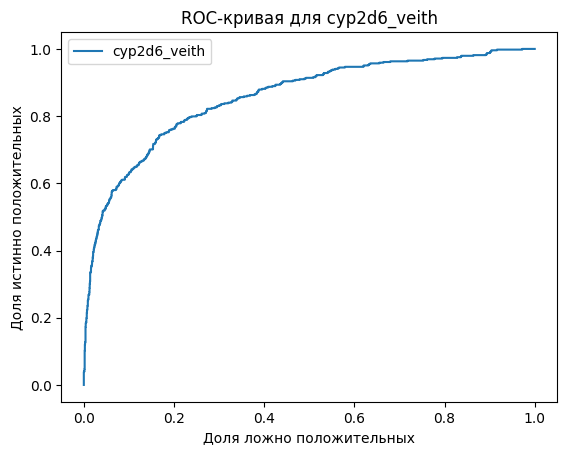

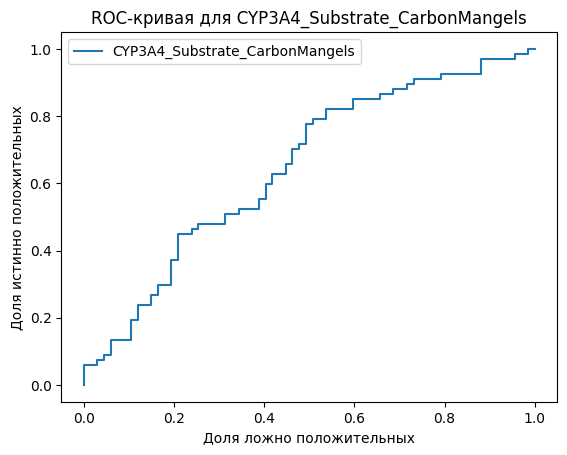

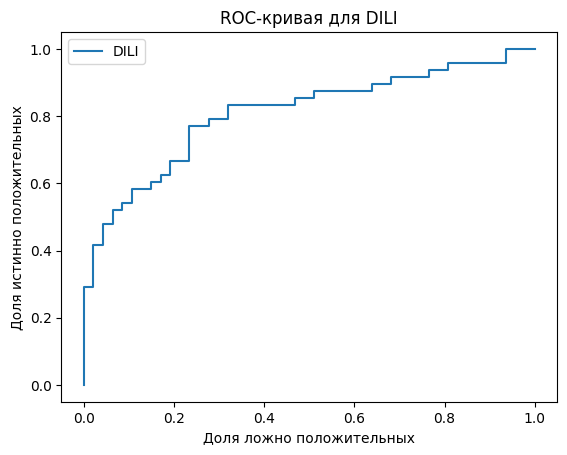

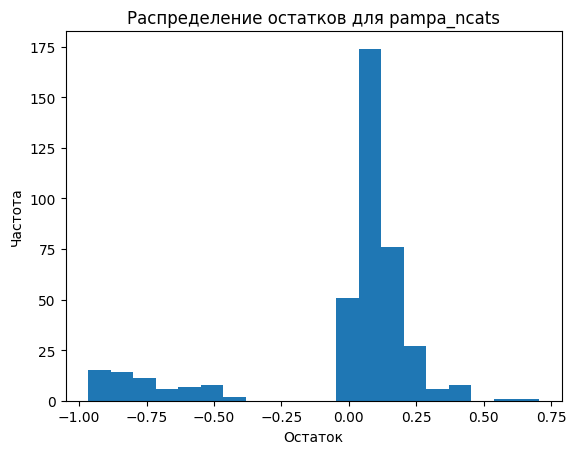

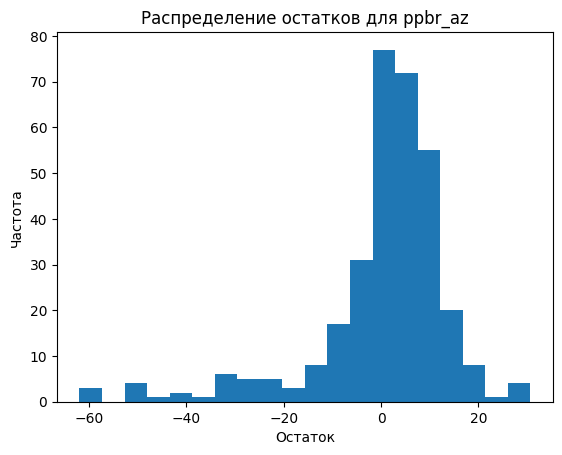

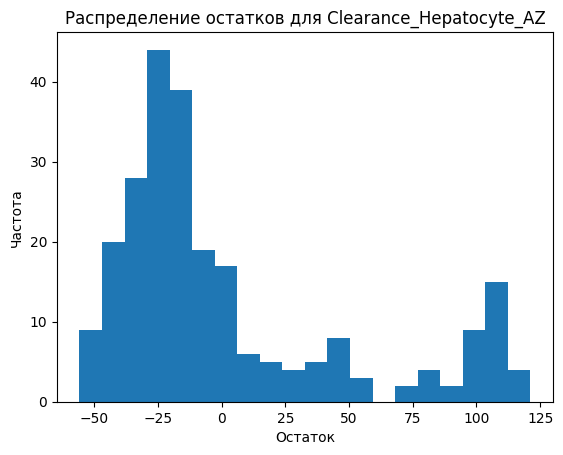

In [21]:
# ROC-кривые для задач классификации
for dataset in datasets['classification']:
    results = all_results[dataset]
    y_test = results['actuals']
    probabilities = results['probabilities']
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    plt.figure()
    plt.plot(fpr, tpr, label=dataset)
    plt.title(f"ROC-кривая для {dataset}")
    plt.ylabel('Доля истинно положительных')
    plt.xlabel('Доля ложно положительных')
    plt.legend()
    plt.show()

# Распределение остатков для регрессионных задач
for dataset in datasets['regression']:
    results = all_results[dataset]
    actuals = results['actuals']
    predictions = results['predictions']
    residuals = actuals - predictions
    plt.figure()
    plt.hist(residuals, bins=20)
    plt.title(f"Распределение остатков для {dataset}")
    plt.ylabel('Частота')
    plt.xlabel('Остаток')
    plt.show()

In [23]:
print("Сравнение моделей:")

for task in ["regression", "classification"]:
    print(f"\n{task.capitalize()} Models:")

    if task == "regression":
        metrics = ['mae', 'r2']
        better_metric = {'mae': 'ниже', 'r2': 'выше'}
    else:
        metrics = ['accuracy', 'f1', 'roc_auc']
        better_metric = {'accuracy': 'выше', 'f1': 'выше', 'roc_auc': 'выше'}

    for metric in metrics:
        if metric in results_df.columns:
            if better_metric[metric] == 'выше':
                best_value = results_df[metric].idxmax()
            else:
                best_value = results_df[metric].idxmin()
            print(f"Лучший {metric} ({better_metric[metric]}) — {results_df.loc[best_value, metric]} для {best_value}")

Сравнение моделей:

Regression Models:
Лучший mae (ниже) — 0.21475321713914505 для pampa_ncats
Лучший r2 (выше) — 0.20604810597725343 для ppbr_az

Classification Models:
Лучший accuracy (выше) — 0.8724295506473724 для cyp2d6_veith
Лучший f1 (выше) — 0.7708333333333333 для DILI
Лучший roc_auc (выше) — 0.8576092832277753 для cyp2d6_veith


Общий вывод. Среди регрессионных моделей наилучшая точность по MAE у pampa_ncats, но лучшая объясняющая способность (R²) у ppbr_az.
Среди классификационных моделей cyp2d6_veith лидирует по accuracy и ROC-AUC, но DILI лучше по F1-score, что может указывать на важность баланса классов.